# TED Talks Dataset Exploratory Data Analysis, Topic Modeling, and Recommendation System

Srikar Murali

3/24/2018

CptS 315

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import ast
import re
import datetime
from pandas.io.json import json_normalize
from pandas.plotting import parallel_coordinates
from wordcloud import WordCloud, STOPWORDS
from time import time
from scipy import stats
from scipy.stats import pearsonr
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [2]:
##Functions

def get_day(x):
    day, month, year = (int(i) for i in x.split('-'))
    answer = datetime.date(year, month, day).weekday()
    return days[answer]

def transform_rating_date(date):
    mod_date =  datetime.date.fromtimestamp(date)
    return mod_date

def convert_to_minutes(t):
    return t/60






These are some functions which will format the data for exploration.

In [3]:
data = pd.read_csv('ted_main.csv') #Data for basic exploratory data analysis


data_r = pd.read_csv('ted_main.csv') #Copy of data for ratings analysis

#Setup for ratings analysis
data_r['film_date'] = data_r['film_date'].apply(transform_rating_date)
data_r['published_date'] = data_r['published_date'].apply(transform_rating_date)

data_r['duration'] = data_r['duration'].apply(convert_to_minutes)
data_r.fillna('Unknown', inplace = True)
data_r['language'] = data_r['languages'].replace(0, 1)
data_r['Talk_ID'] = range(1, len(data_r) + 1)

transcript = pd.read_csv('transcripts.csv')



Read in data and format data_r for future rating analysis.

## Popular Talks

#### Setup and format dates

In [4]:

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

data = data[['name', 'title', 'description', 'main_speaker', 'speaker_occupation', 
         'num_speaker', 'duration', 'event', 'film_date', 'published_date', 
         'comments', 'tags', 'languages', 'ratings', 'related_talks', 'url', 'views']]

data['film_date'] = data['film_date'].apply(lambda x: datetime.datetime.fromtimestamp(int(x)).strftime('%d-%m-%Y'))
data['published_date'] = data['published_date'].apply(lambda x: datetime.datetime.fromtimestamp(int(x)).strftime('%d-%m-%Y'))

most_popular_talks = data[['title', 'main_speaker', 'views', 'film_date']].sort_values('views', ascending=False)[:25]
most_popular_talks['first_name'] = most_popular_talks['main_speaker'].apply(lambda x: x[:x.index(' ')])


Retrieve most popular talks and format data.

#### Graph popular talks


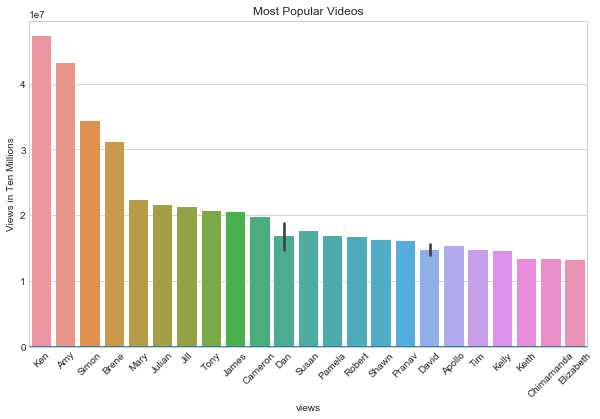

In [5]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
g = sns.barplot(x='first_name', y='views', data=most_popular_talks)
plt.title("Most Popular Videos")
plt.ylabel("Views in Ten Millions")
plt.xlabel("Speaker First Name")
plt.xticks(rotation=45)


sns.set(font_scale=1)
sns.distplot(data[data['views'] < 0.4e7]['views'])
plt.show()


The most popular talk is by Sir Ken Robinson.

### Talks by Day, Month and Year

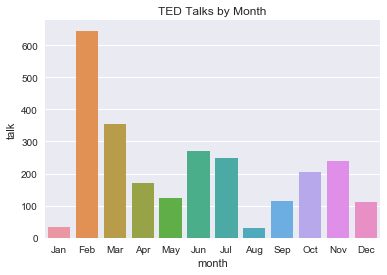

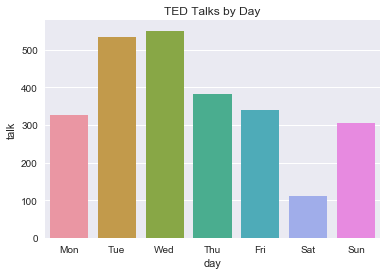

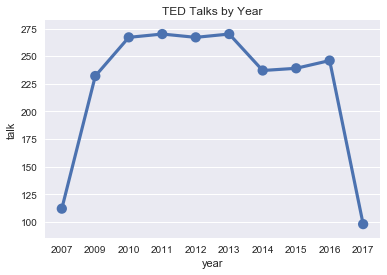

In [6]:

data['month'] = data['film_date'].apply(lambda x: months[int(x.split('-')[1]) - 1])

data_months = pd.DataFrame(data['month'].value_counts()).reset_index()
data_months.columns = ['month', 'talk']

sns.barplot(x='month', y ='talk', data=data_months, order=months)
plt.title('TED Talks by Month')
data['day'] = data['film_date'].apply(get_day)
plt.show()
#
data_days = pd.DataFrame(data['day'].value_counts()).reset_index()
data_days.columns = ['day', 'talk']
#
sns.barplot(x='day', y='talk', data=data_days, order=days)
plt.title('TED Talks by Day')
plt.show()

data['year'] = data['film_date'].apply(lambda x: x.split('-')[2])
data_years = pd.DataFrame(data['year'].value_counts()).reset_index()
data_years.columns = ['year', 'talk']
#
sns.pointplot(x='year', y='talk', data=data_years.head(10))
plt.title('TED Talks by Year')
plt.show()

February is the most popular month for a TED talk, and the number of talks increased dramatically in 2009, but decreased dramatically in 2017. (Though this may just be due to the data not recording all of the talks in 2017.)

### Heatmap of Talks by month and year


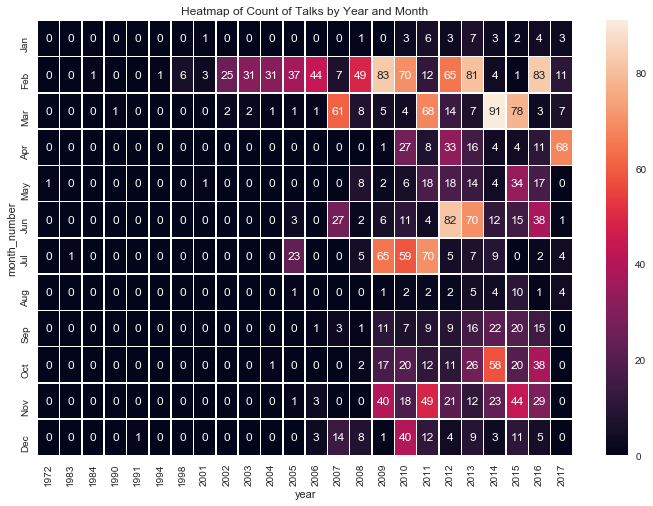

In [7]:
month_dict = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 
          'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}


hm_data = data.copy()
hm_data['film_date'] = hm_data['film_date'].apply(lambda x: months[int(x.split('-')[1]) - 1]
 + " " + str(x.split('-')[2]))

hm_data = pd.pivot_table(hm_data[['film_date', 'title']], index='film_date', aggfunc='count').reset_index()

hm_data['month_number'] = hm_data['film_date'].apply(lambda x: month_dict[x.split()[0]])
hm_data['year'] = hm_data['film_date'].apply(lambda x: x.split()[1])
hm_data = hm_data.sort_values(['year', 'month_number'])
hm_data = hm_data[['month_number', 'year', 'title']]
hm_data = hm_data.pivot('month_number', 'year', 'title')
hm_data = hm_data.fillna(0)

f, ax = plt.subplots(figsize=(12, 8))
plt.title('Heatmap of Count of Talks by Year and Month')
sns.heatmap(hm_data, annot=True, linewidths = 0.5, ax = ax, fmt = 'n', yticklabels = months)
plt.show()

To create this heatmap first format the data and count the talks for each year by month. Pivot the data by film date and title and then sort and pivot by year and month. Finally deal with the NA's and plot the data. 

February and March have always been very popular months for talks.

## Occupation Analysis


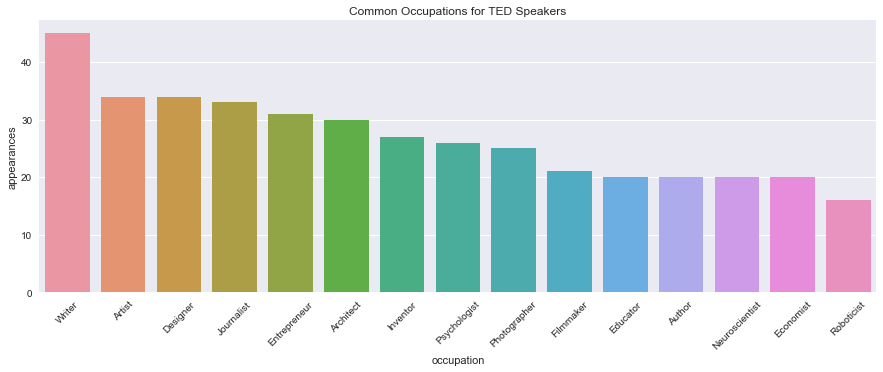

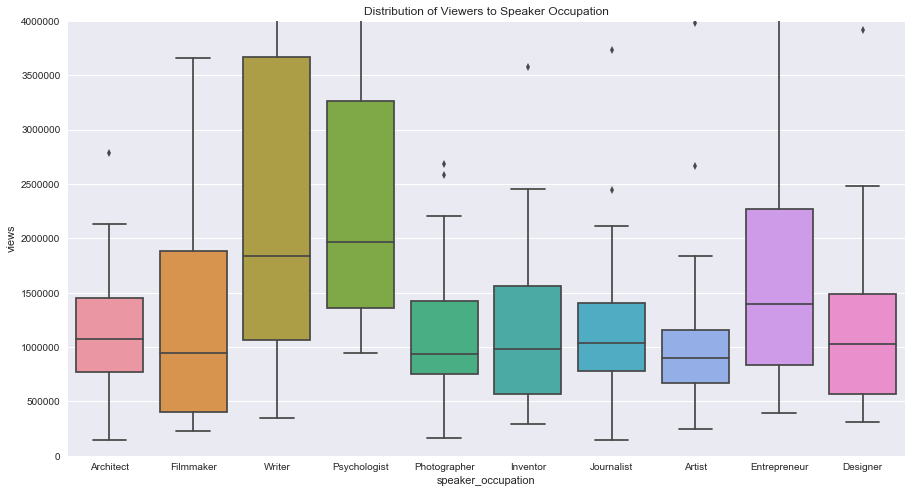

In [8]:

data_occupation = data.groupby('speaker_occupation').count().reset_index()[['speaker_occupation', 'comments']]
data_occupation.columns = ['occupation', 'appearances']
data_occupation = data_occupation.sort_values('appearances', ascending=False)

plt.figure(figsize=(15,5))
plt.title('Common Occupations for TED Speakers')
plt.xticks(rotation=45)
sns.barplot(x='occupation', y='appearances', data=data_occupation.head(15))
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(15, 8))
plt.title('Distribution of Viewers to Speaker Occupation')
sns.boxplot(x='speaker_occupation', y='views', data=data[data['speaker_occupation'].isin(data_occupation.head(10)['occupation'])], ax=ax)
ax.set_ylim([0, 0.4e7])
plt.show()

Writers and artists are by far the most common speakers. Writers have the highest median value for views. Artists though are amongst the occupations which get the fewest views. Psychologist's have the second highest median views value but are ranked eighth in terms of appearances.

## Languages

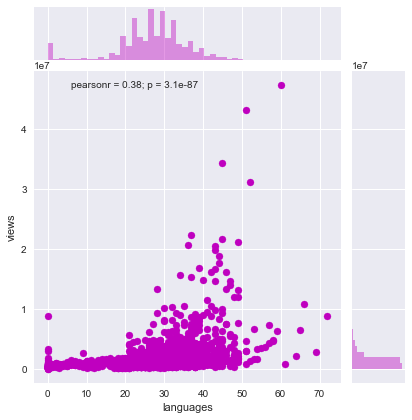

In [9]:


sns.jointplot(x='languages', y='views', data=data, color='m')
plt.show()


themes_of_talks = data.apply(lambda x: pd.Series(x['tags']), axis=1).stack().reset_index(level=1, drop=True) #convert column to series
themes_of_talks.name = 'theme' #name series

data_themes = data.drop('tags', axis=1).join(themes_of_talks)


themes_top = pd.DataFrame(data_themes['theme'].value_counts()).reset_index()
themes_top.columns = ['theme', 'talks']

Most talks are translated in around 30-40 languages, and recieve less than 1 million views.

## Most Popular Topics

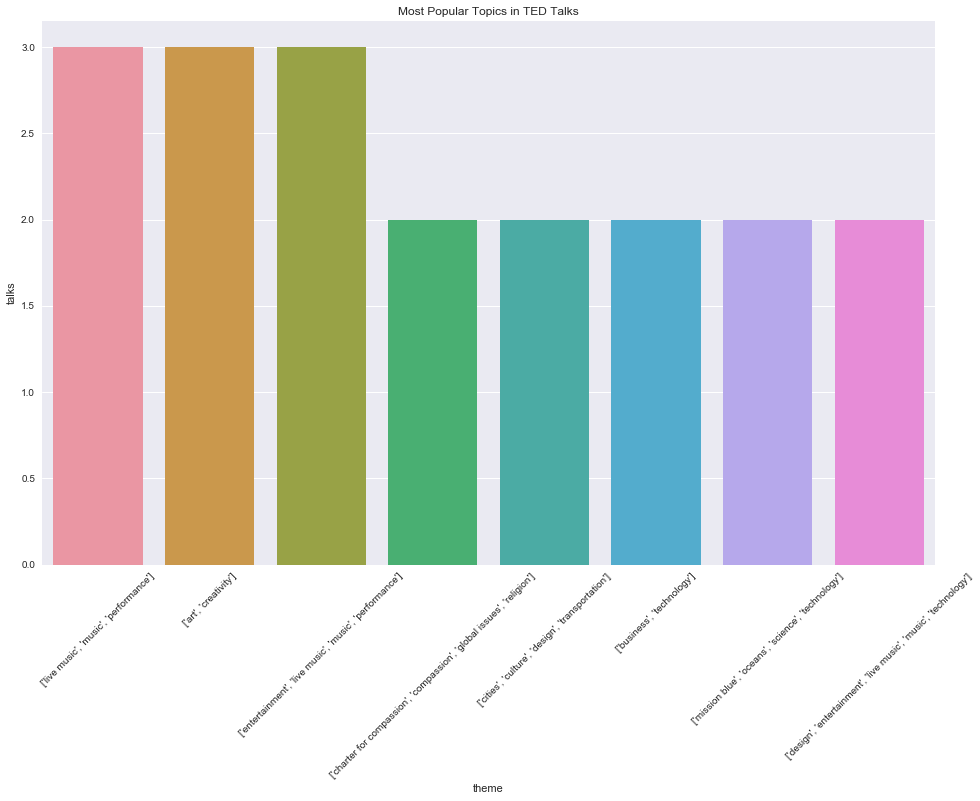

In [10]:

themes_top = pd.DataFrame(data_themes['theme'].value_counts()).reset_index()
themes_top.columns = ['theme', 'talks']

plt.figure(figsize=(16,10))
plt.title('Most Popular Topics in TED Talks')
plt.xticks(rotation=45)
plt.xlabel("Words in Topic")
sns.barplot(x='theme', y='talks', data=themes_top.head(8))
plt.show()

Artistic topics seems to be far more popular than technology, politics, or any other field.

#### Barplot and lineplot of popular topics


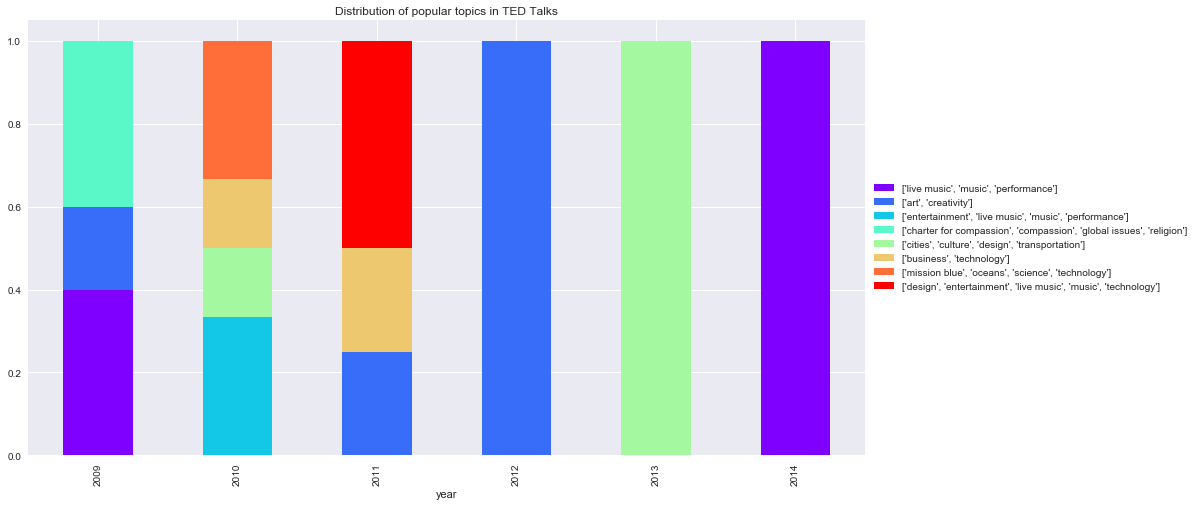

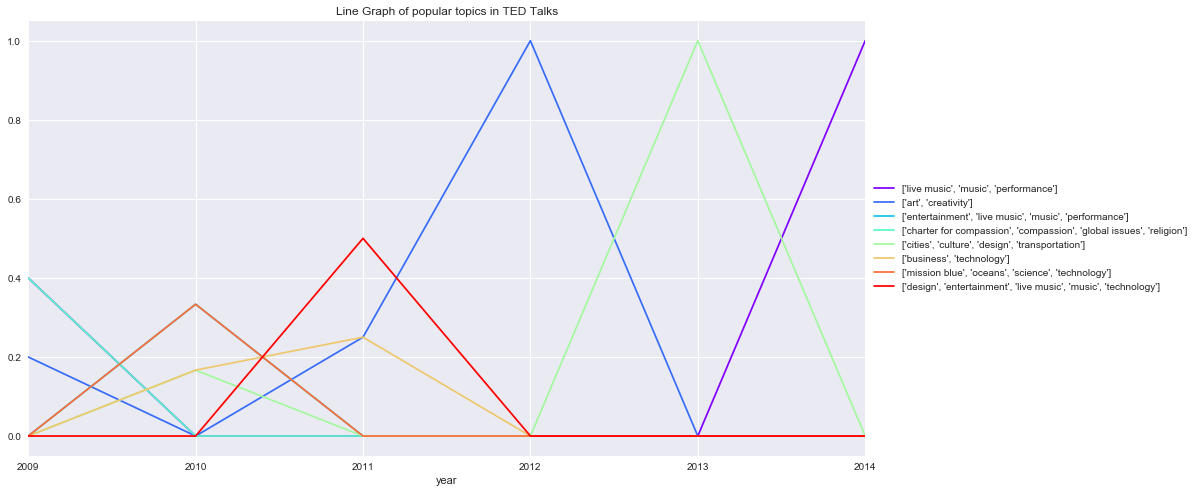

In [11]:
theme_top_talks = data_themes.loc[(data_themes['theme'].isin(themes_top.head(8)['theme'])) &
                    (data_themes['theme'] != 'TEDx')]
                    
theme_top_talks['year'] = theme_top_talks['year'].astype('int')
theme_top_talks = theme_top_talks.loc[theme_top_talks['year'] > 2008]

popular_topics = list(themes_top.head(8)['theme'])

bar_color_dist = pd.crosstab([theme_top_talks['year']], theme_top_talks['theme']).apply(lambda x: x/x.sum(), axis=1) #Creates a cross table which is a table with the columns on top containing the value
bar_color_dist[popular_topics].plot(kind='bar', stacked=True, colormap='rainbow', figsize=(15, 8), title='Distribution of popular topics in TED Talks').legend(loc='center left', bbox_to_anchor=(1,0.5))
bar_color_dist[popular_topics].plot(kind='line', stacked=False, colormap='rainbow', figsize=(15, 8), title='Line Graph of popular topics in TED Talks').legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.show()

To create these graphs use a cross tab for the year and theme. A cross tab merely computes a frequency table. Then convert the counts into proportions.

The number of technology related talks has increased each year while the number of culture related talks has decreased significantly. The proportion of artistic talks had a very large increase in 2012. In fact almost all of the talks in 2012 were art related.

#### Box plot of topics


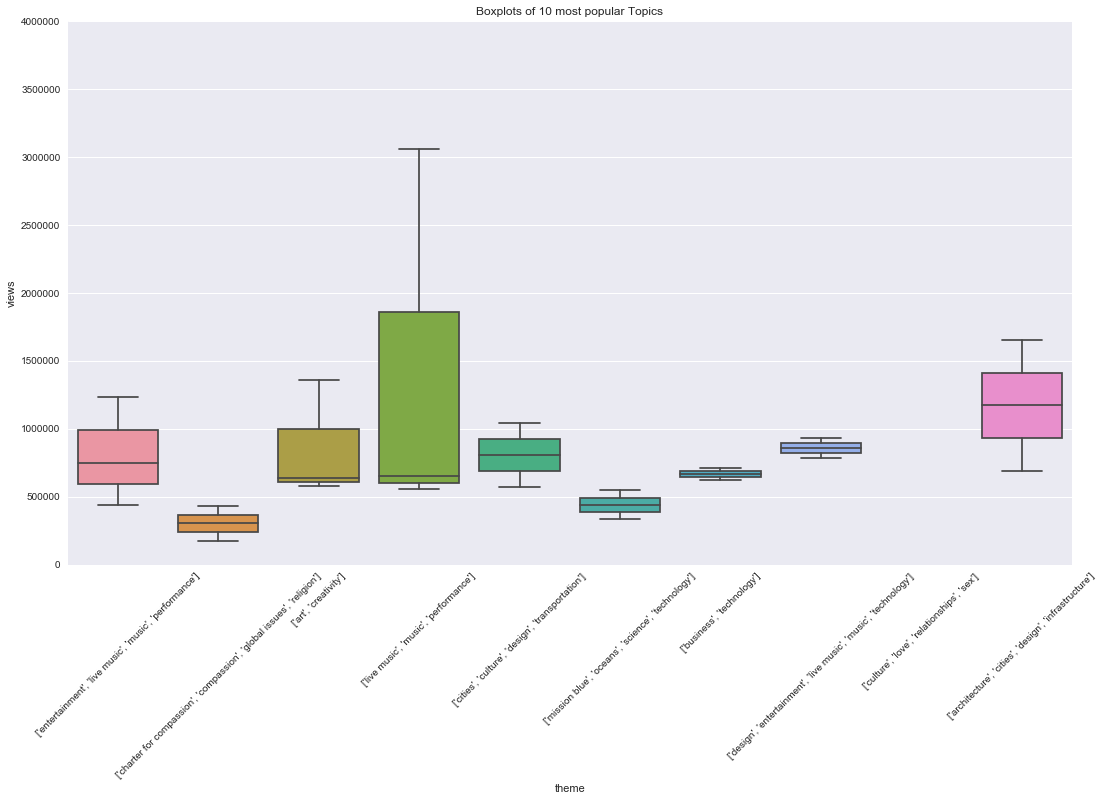

In [12]:
theme_top_talks = data_themes[data_themes['theme'].isin(themes_top.head(10)['theme'])]
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(18, 10))
plt.title('Boxplots of 10 most popular Topics')
plt.xticks(rotation=45)
sns.boxplot(x='theme', y='views', data=theme_top_talks, ax = ax)
ax.set_ylim([0, 0.4e7])
plt.show()

Music and performance has a very large range, though culture related talks seem to have the highest median view count.

## Wordcloud of Transcript


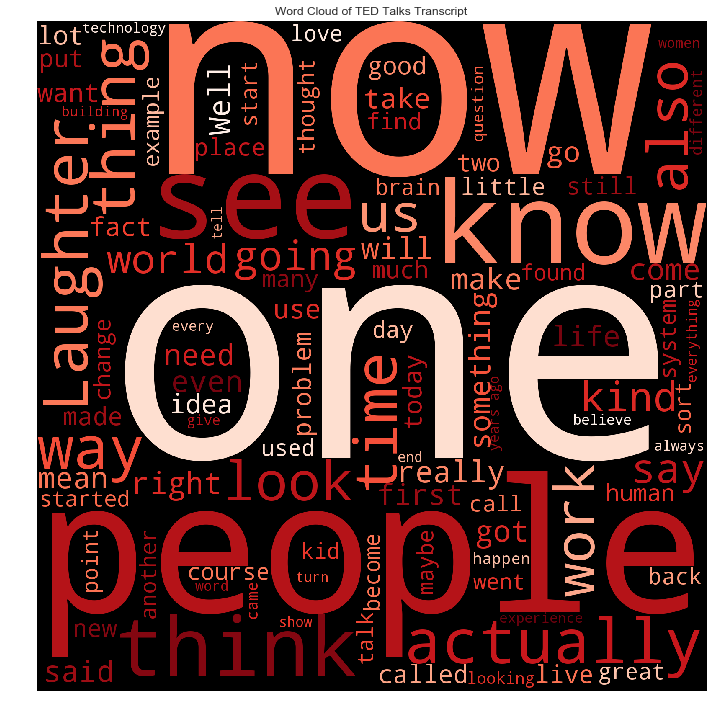

In [13]:
words = ' '.join(transcript['transcript'])
wordcloud = WordCloud(stopwords = STOPWORDS, background_color='black', max_words=100,width=1600, height=1600, colormap='Reds').generate(words)

plt.figure(figsize=(12,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Word Cloud of TED Talks Transcript')
plt.show()

Many of the words in the wordcloud deal with people and life. They seem to be inspirational in nature. In addition there are many common words since most of the stopwords were not removed.

## Rating data correlation and analysis


#### Setup for Analysis


In [14]:


rating_id = set()
for i, j in data_r.iterrows():
    r = ast.literal_eval(j['ratings'])
    for rating in r:
        rating_id.add(rating['name'])
        
all_ratings = defaultdict(list)
for i, j in data_r.iterrows():
    r = ast.literal_eval(j['ratings'])
    all_ratings['Talk_ID'].append(j['Talk_ID'])
    n = set()
    for rating in r:
        all_ratings[rating['name']].append(rating['count'])
        n.add(rating['name'])
        


Create a rating dictionary which consists of Talk_ID and the count of ratings for each talk.

In [15]:
def convert_to_percent(col):
    return (col/all_ratings['total_votes'])*100

all_ratings = pd.DataFrame(all_ratings)

all_ratings['total_votes'] = all_ratings.sum(axis=1) #get total votes per rating
all_ratings = all_ratings.sort_values('total_votes', ascending=False)
all_ratings.loc[:, (all_ratings.columns != 'total_votes') & (all_ratings.columns != 'Talk_ID')] = \
                all_ratings.loc[:, (all_ratings.columns != 'total_votes') & (all_ratings.columns != 'Talk_Id')].apply(convert_to_percent) #convert votes to percentage of total

Convert to percentages.

In [16]:
##Tag data setup/cleaning
tags = defaultdict(list)
#First append Talk_id then tag
for i, j in data_r.iterrows():
    topics = ast.literal_eval(j['tags'])
    for t in topics:
        tags['Talk_ID'].append(j['Talk_ID'])
        tags['tags'].append(t)


tags = pd.DataFrame(tags)

Add the Talk_ID to the tag data.

In [17]:
##Occupation data setup/removing uneeded characters
char_un = re.compile(r'[=\+/&<>;\"\-\?%#$@\,\t\r\n]| and ')

remove_occ_chars = defaultdict(list)

#Find all unneeded characters in the speaker occupation
for i, j in data_r.iterrows():
    o = j['speaker_occupation']
    c = char_un.search(o)
    if c:
        c = c.group()
        remove_occ_chars[c].append(o)
        
        several_occs_c = re.compile(r'\/|\,|\;|\+| and ')
end_c = re.compile(r' \.\.\.')
occ = defaultdict(list)
#Do not want to split these
ignore = ['HIV/AIDS fighter','9/11 mothers']

for i, j in data_r.iterrows():
    o = j['speaker_occupation']
    flag = False # check if problem
    if several_occs_c.search(o):
        flag = True #found unneeded character
    if flag and (o not in ignore):
        o = re.split('\/|\,|\;|\+| and ', o)
        for k in o:
            occ['Talk_ID'].append(j['Talk_ID'])
            if end_c.search(k): #if unneeded ending char
                k = k.strip(' ...')
            occ['speaker_occupation'].append(k.strip().lower()) #convert to lower to avoid mismatching same stringr
    else:
        occ['Talk_ID'].append(j['Talk_ID'])
        occ['speaker_occupation'].append(o.lower())

occ = pd.DataFrame(occ)

        
    
key_features = data_r[['Talk_ID', 'title', 'duration', 'comments', 'views', 'languages']]



### Analysis of Rating Data - Main Ratings


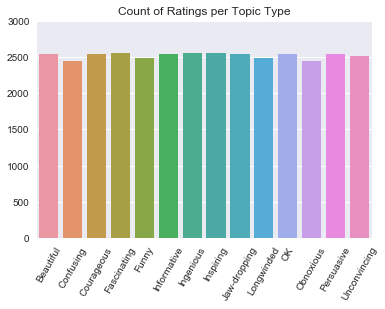

In [18]:

ratings_per_topic = defaultdict(list)
for r in all_ratings.columns:
    if (r != 'Talk_ID') and (r != 'total_votes'):
        ratings_per_topic['rating'].append(r)
        ratings_per_topic['count'].append(all_ratings[all_ratings[r] > 0][r].count())

plt.title("Count of Ratings per Topic Type")
sns.barplot(x='rating', y='count', data=ratings_per_topic)
plt.xticks(rotation=60)
plt.ylim(0, 3000)
plt.show()

The rating counts for the topics is pretty similar.

#### Classify Talk by type with highest rating


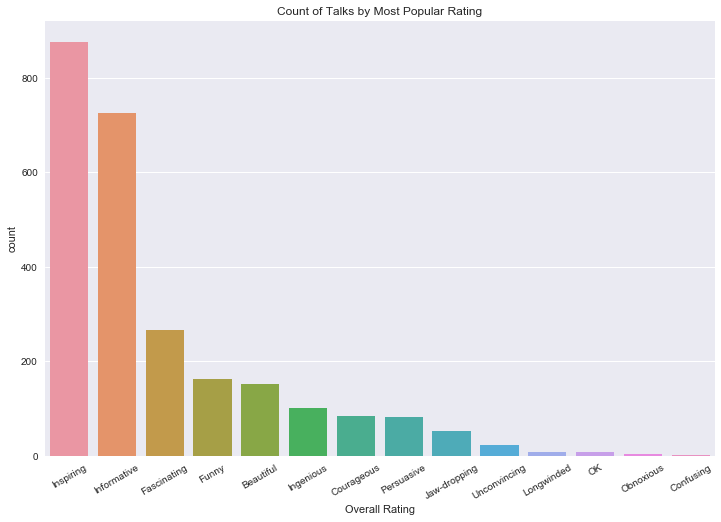

In [19]:
r_val = all_ratings.loc[:, (all_ratings.columns != 'total_votes') & (all_ratings.columns != 'Talk_ID')]
all_ratings['in_rat_ct'] = r_val.apply(np.argmax, axis=1)
ord_l = all_ratings['in_rat_ct'].value_counts().sort_values(ascending = False).index

f, ax = plt.subplots(figsize=(12,8))
plt.title('Count of Talks by Most Popular Rating')
ax = sns.countplot(x='in_rat_ct', data=all_ratings, order=ord_l)
plt.xticks(rotation=30)
plt.xlabel('Overall Rating')
#draw boxplot of most popular type part by part using patches.
for part in ax.patches:
    h = part.get_height()
    w = part.get_x() + part.get_width()/2.0
    
plt.show()




This graph is drawn part by part using patches. Each topic count is drawn one by one.

After classifying each talk with the rating they recieved the most votes for, it appears that most people tend to rate talks as either inspiring or informative.

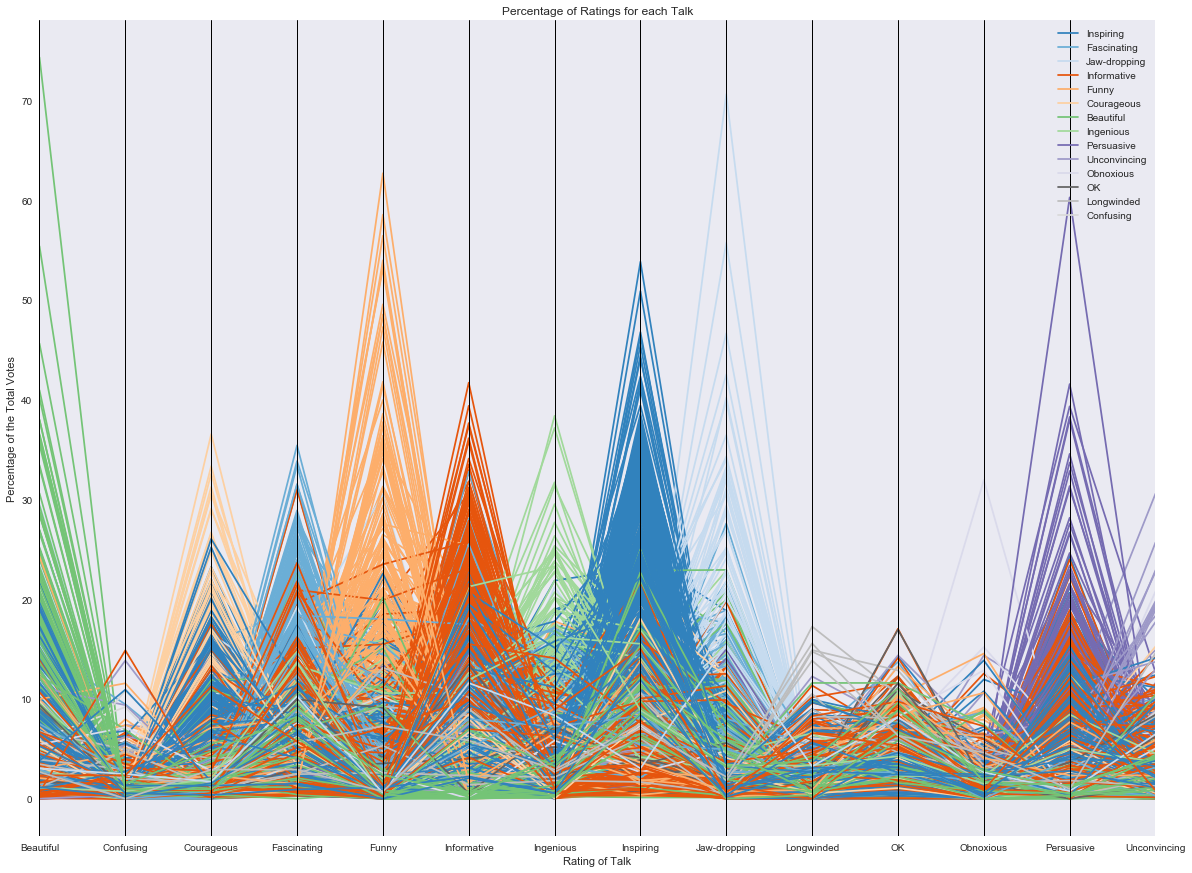

In [20]:
#Votes in Percentages of each TED Talk for each Rating
r_val_new = all_ratings.loc[:, (all_ratings.columns != 'total_votes') &  (all_ratings.columns !='Talk_ID')]
plt.figure(figsize=(20,15))
plt.title('Percentage of Ratings for each Talk')
plt.xlabel("Rating of Talk")
plt.ylabel("Percentage of the Total Votes")


#Most talks have great acceptance by public, lines are thicker where more ratings are given
parallel_coordinates(r_val_new, 'in_rat_ct', colormap = 'tab20c')
plt.show()

This plot showcases the most people rate topics as inspiring, informative, or funny. Based on this plot it can be said that talks which are rated as funny are also rated as informative or inspiring, since despite the number of votes for funny, it isn't the most popular rating.

#### View correlation to rating


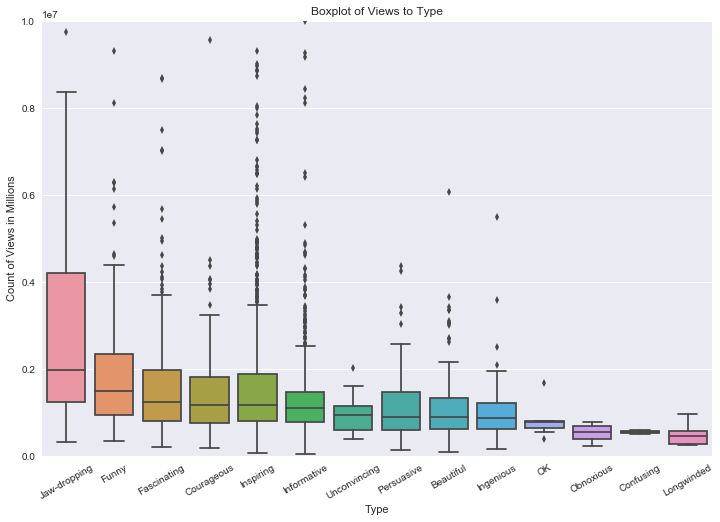

In [21]:
base_rate = key_features.merge(all_ratings, how='left', on=['Talk_ID'])
view_corr_rate = base_rate.groupby('in_rat_ct')['views'].median().sort_values(ascending=False).index #Get index of median view per overall type

f, ax = plt.subplots(figsize=(12,8))
plt.ylim((0,10000000))

ax = sns.boxplot(x='in_rat_ct', y='views', data=base_rate, order=view_corr_rate)
plt.xlabel('Type')
plt.ylabel('Count of Views in Millions')
plt.title('Boxplot of Views to Type')
plt.xticks(rotation = 30)
plt.show()



After merging the key features dataframe with the ratings dataframe, the count of views for each tag is observed. The Jaw-dropping tag seems to very common and has the largest median and max view count. The inspiring tag has many large outliers however.

#### Duration correlation to rating


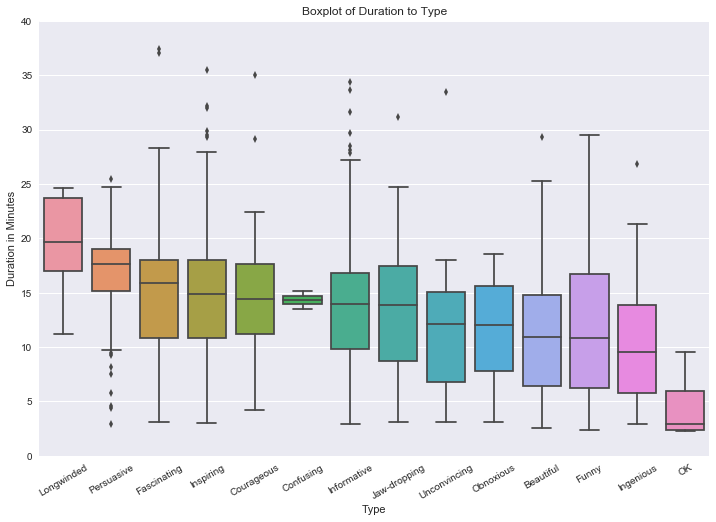

In [22]:
dur_corr_rate = base_rate.groupby('in_rat_ct')['duration'].median().sort_values(ascending=False).index #Get index of median duration per overall type

f, ax = plt.subplots(figsize=(12,8))

ax = sns.boxplot(x='in_rat_ct', y='duration', data=base_rate, order=dur_corr_rate)
plt.xlabel('Type')
plt.ylabel('Duration in Minutes')
plt.title('Boxplot of Duration to Type')
plt.ylim((0,40))
plt.xticks(rotation = 30)
plt.show()
    

As expected the longwinded tag has the largest median talk duration. Most of the other tags have similar ranges, though talks associated with a negative tag seem to have shorter durations. 

#### Heatmap of correlation between type and features


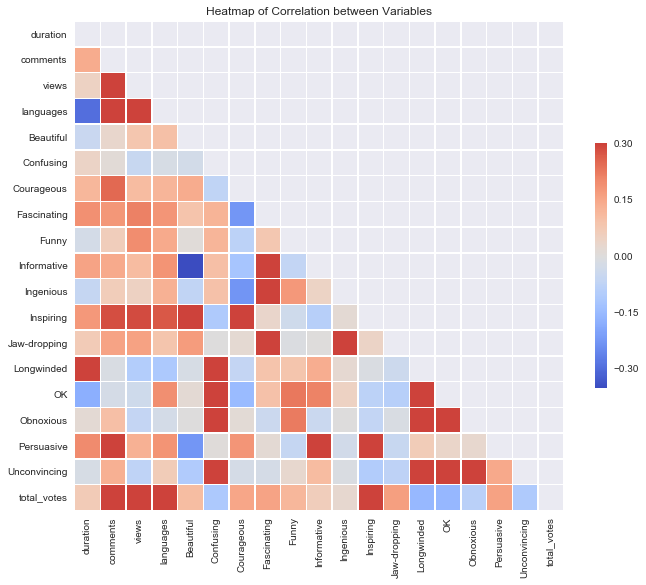

In [23]:

#No correlation between talk_id and title

corr = base_rate.drop(['Talk_ID', 'title'], axis=1).corr() 
#Start drawing heatmap piece by piece

#Mask for upper triangle so we don't repeat 

m = np.zeros_like(corr, dtype=np.bool) #create mask of the same size as corr
m[np.triu_indices_from(m)] = True #Get upper triangular indices

f, ax = plt.subplots(figsize=(11, 9))


sns.heatmap(corr, mask=m, cmap='coolwarm', vmax=0.3, center=0, square=True, linewidths=0.5, cbar_kws={'shrink':0.5})
plt.title('Heatmap of Correlation between Variables')
plt.show()


To create this heatmap first get the correlation and create a matrix of zeros in the same format as the correlation matrix. Get the upper triangular indices and plot only those. From the heatmap there seems to significant correlation between languages, comments and views. Negative tags are highly correlated and inspiring talks have strong correlation to views, comments and languages.

## Topic Modeling Functions


In [24]:
def rankings(t, mat):
    s = mat.sum(axis=0)
    data = []
    for column, current_word in enumerate(t):
        data.append((current_word, s[0,column]))
    r = pd.DataFrame(data, columns=['term','rank']).sort_values('rank', ascending=False)
    return r

This function returns the ranking of the term in the data.

#### Setup for Topic Modeling


In [25]:

vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, ngram_range=(1,1), min_df = 0.05, max_df=0.3) #Get only 1-grams and cut words which appear in less than 5% of documents and more than 30% of documents
term_invdoc_freq = vectorizer.fit_transform(transcript['transcript'])
top_words = rankings(vectorizer.get_feature_names(), term_invdoc_freq)


Initialize the vectorizer to use TF-IDF ratings to find the 1-grams in the transcript. The vectorizer ignores words which appear in less than 5% of the documents and in more than 30% of the documents. Fit the vectorizer to the transcript and then retrieve the top words.

#### Wordcloud of Transcript from Frequencies with Stopwords removed


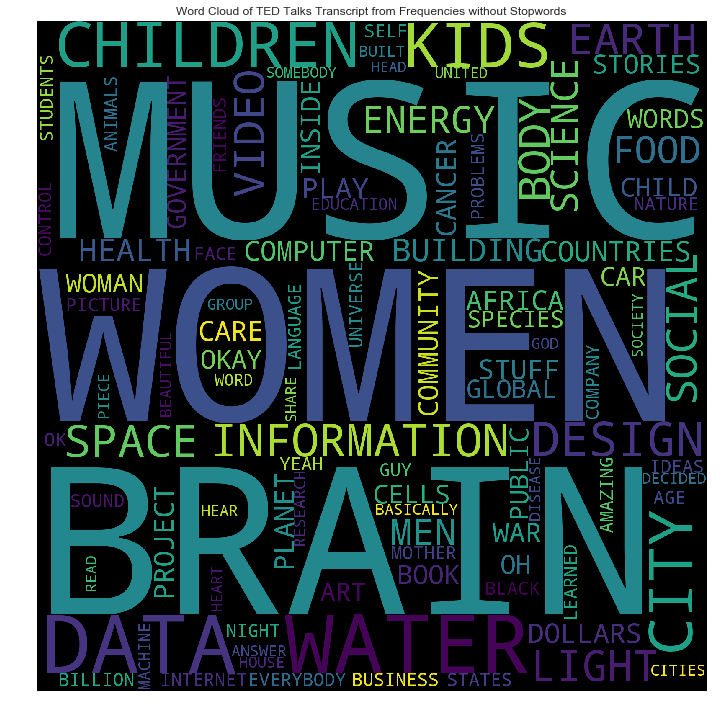

In [26]:
d = {top_words.loc[i, 'term'].upper(): top_words.loc[i, 'rank'] for i in range(0, len(top_words))} #Get word at each rank and transform it into uppercase

wc = WordCloud(background_color='black', max_words=100, width=1600, height=1600).generate_from_frequencies(d)

plt.figure(figsize=(12,15))
plt.imshow(wc)
plt.axis('off')
plt.title('Word Cloud of TED Talks Transcript from Frequencies without Stopwords')
plt.show()

Compared to the wordcloud without the stopwords removed, this one better showcases the topics. From this wordcloud it can be observed that art, music, women, family, politics, technology and the environment are some of the most popular topics.

#### Latent Dirichlet Allocation Topic Modeling


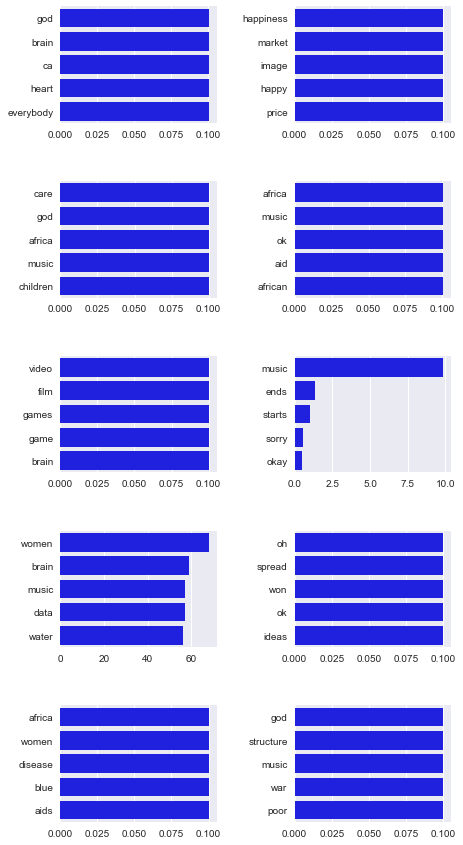

In [27]:

#Intialize Topic model lda
lda = LatentDirichletAllocation(n_components=10, learning_method='online',random_state=101)
#Fit model to the TFIDF scores
total_topics = lda.fit_transform(term_invdoc_freq)
head = 5
words, power = {}, {}

#Get the top 5 words for each topic

for term_id, term in enumerate(lda.components_):
    words[term_id] = [vectorizer.get_feature_names()[i] for i in term.argsort()[:-head-1:-1]]
    power[term_id] = term[term.argsort()[:-head-1:-1]]
    
fig, ax = plt.subplots(figsize=(7,15), ncols=2, nrows=5)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

#Barplot for top words in each topic, arranged in 5x2 grid from LDA
k = 0
for i in range(0, 5):
    for j in range(0, 2):
        sns.barplot(x=power[k], y=words[k], color='blue', ax=ax[i][j])
        k+=1
plt.show()

The LDA goes through each topic, finds the top five words that represent each topic and graphs the distribution of those words. Latent Dirichlet Allocation works in several steps. First it determines how many words a document will have and computes the distribution of each topic from the terms. It then tries to generate each term from the topic distribution. It does this by picking a topic from the generated distributions. The LDA creates a collection of documents and then backtracks from the documents to find a set of topics that are likely to have generated the collection. 

LDA learns by going through each document and first randomly assigning each word in the document to one of the K-topics. It then will keep doing this for each word in each document until the assignment is roughly the same each time. It assigns the topic through this probability function: $p(topic_t | document_d) * p(word_w | topic_t)$.

#### Non-Negative Matrix Factorization Topic Modeling


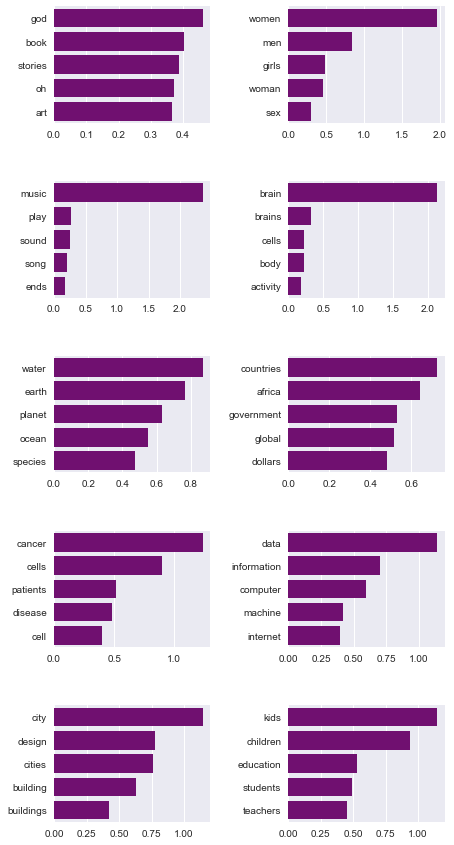

In [28]:

#Intialize Topic model nmf
nmf = NMF(n_components=10, random_state=101)
total_topics = nmf.fit_transform(term_invdoc_freq)
head = 5

words, power = {}, {}
#Get the top 5 words for each topic

for term_id, term in enumerate(nmf.components_):
    words[term_id] = [vectorizer.get_feature_names()[i] for i in term.argsort()[:-head-1:-1]]
    power[term_id] = term[term.argsort()[:-head-1:-1]]

fig, ax = plt.subplots(figsize=(7,15), ncols=2, nrows=5)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

#Barplot for top words in each topic, arranged in 5x2 grid from LDA
k = 0
for i in range(0, 5):
    for j in range(0, 2):
        sns.barplot(x=power[k], y=words[k], color='purple', ax=ax[i][j])
        k+=1
plt.show()



The steps for the NMF model is similar to the LDA. The NMF model seems to retrieve the topics better than the LDA since the words for each topic are more distinct and the distribution of the words is more spread. Several of the topics seem to deal with art, science, the environment, education, and culture.

Non-Negative Matrix Factorization takes a term-document matrix as an input and generates a set of topics that represent weighted sets of co-occuring terms. It breaks down the data by creating a user-defined number of features which are a combination of the original attribute set. It is mainly used for feature extraction when there are many ambiguous attributes; in this case it is used for topic extraction. These coefficients are non-negative. It breaks down the original data features into two lower ranked matrices, and then uses an iterative approach to modify the lower ranked matrices so that their product approaches the orignal. When the approximation error converges or the user-defined maximum iterations is reached, the NMF stops. Before using NMF that data had to be prepared; the numeric attributes had to normalized, the missing values were replaced with the mean and the categorical values are replaced with the mode.  Any outliers need to removed or changed since they will impact the model.  

#### Pipeline for NMF Process

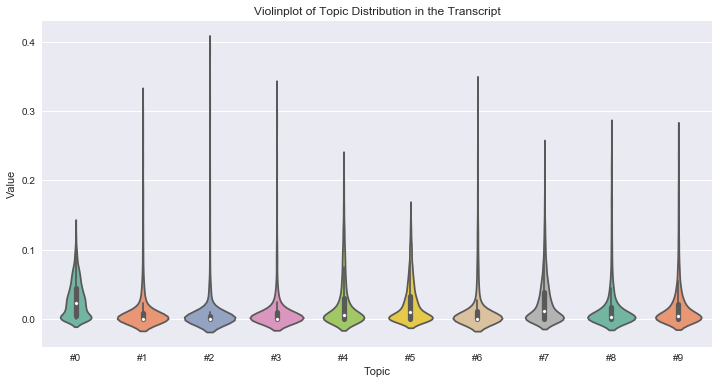

In [29]:
##Create Pipeline to do topic modeling process, and graph the distribution of the top 10 topics

#Sequentially apply transformation.
#First apply tfidf scoring to vectorizer and then apply non-negative matrix factorization to the nmf topic model
pipe = Pipeline([('tfidf', vectorizer), ('nmf', nmf)])

#Transforms data into tf-idf score and then applys nmf topic model
tran = pipe.transform(transcript['transcript'])
tran = pd.DataFrame(tran, columns=['#{}'.format(i) for i in range(10)])

#Intialize dataframe for graphing with value and then topic
graph_tran = pd.DataFrame({'value':tran['#0'].values, 'topic':['#0']*len(tran)})                                 
#Add to graph dataframe
for term_id in tran.columns[1:]:
    graph_tran = pd.concat([graph_tran, pd.DataFrame({'value':tran[term_id].values, 'topic':[term_id]*len(tran)})])

fig = plt.figure(figsize=(12,6))
sns.violinplot(x='topic', y='value', data=graph_tran, palette='Set2')
plt.xlabel('Topic')
plt.ylabel('Value')
plt.title('Violinplot of Topic Distribution in the Transcript')
plt.show()



This sets up a pipeline to do the whole vectorization and NMF topic modeling in one motion. The violin plot shows the distribution of each topic compared to the documents.

Topic 0 is very general so it covers a lot of the documents but topics 4,5,7,9 have higher quartiles and also represent a good amount of documents The boxplot in each topic demonstrates the proportion of documents in the collection covered by the topic.


## Recommending Similar Topics


In [30]:
##Functions

#Sorts similarity for each row in matrix and return the the top 5 most similar talks
def find_related_talks(t, k):
    return ' '.join(transcript['title'].loc[t.argsort()[-k:-1]])


Retrieves the top-k most common talks.

In [54]:
#Extract title of Talk From URL
transcript['title'] = transcript['url'].map(lambda x: x.split("/")[-1])

#Transform words into TF-IDF score, then place scores into a matrix
t = transcript['transcript'].tolist()

#Example words in matrix
print(t[0][0:12])
turn_into_tfidf = TfidfVectorizer(input=t, stop_words='english')

#Get tfidf scores and place it in a matrix
m = turn_into_tfidf.fit_transform(t)

#TF-IDF matrix
print(m)

#similarity measure
similarity = cosine_similarity(m)

#Find related talks for each talk
transcript['related_talks'] = [find_related_talks(i, 5) for i in similarity]

Good morning
  (0, 22442)	0.0207893511919
  (0, 34082)	0.0130546957013
  (0, 29661)	0.255170755522
  (0, 22767)	0.0236033537079
  (0, 23769)	0.0175912125136
  (0, 55708)	0.0410919991987
  (0, 6739)	0.0226749608268
  (0, 4664)	0.0172796410847
  (0, 52365)	0.0391744083742
  (0, 19074)	0.0236033537079
  (0, 29839)	0.0342704231208
  (0, 52271)	0.0258707093722
  (0, 45069)	0.0269777561086
  (0, 11459)	0.0344556338103
  (0, 43367)	0.0198370462907
  (0, 56576)	0.056001182117
  (0, 51448)	0.0237987468233
  (0, 18924)	0.064560386938
  (0, 18427)	0.0302459607493
  (0, 25126)	0.0600700206546
  (0, 12663)	0.092792550292
  (0, 40610)	0.0544446170392
  (0, 38539)	0.0892785628888
  (0, 28351)	0.0425645817722
  (0, 55654)	0.0191398725325
  :	:
  (2466, 42500)	0.0772609092427
  (2466, 23266)	0.0377482266057
  (2466, 37094)	0.0367370920802
  (2466, 12658)	0.0959228679653
  (2466, 14324)	0.0515142172579
  (2466, 40147)	0.042453664438
  (2466, 39520)	0.0468087794255
  (2466, 16106)	0.0752591175889
  (2466

The TF-IDF matrix contains the document number, the index of the word in the original document and the TF-IDF score. There are over 2400 documents and each document may contain thousands of words which makes the TF-IDF matrix large as well.

First extract the title from the url and initialize a TF-IDF vectorizer. Transform the transcript data into a matrix of TF-IDF values and compute the cosine similarity between vectors to find the related talks. The features which contribute to the recommendation system are the words in the vector, specifically the words which have a high TF-IDF score. These words are usually uncommon words which do not appear in many documents. The above "Good Morning" would have a low TF-IDF score since it is rather common in the talks. Words which relate to the speaker's name and topic will most likely have the highest TF-IDF scores. In the case of a Hans Rosling talk, the talks which are similar will most likely be other talks done by Hans Rosling since his name will have a high TF-IDF score. In general for this data set, the name of the speaker seems to be the greatest determinant of similarity between talks, while the topic of the talks is the second most useful determinant. The system might could be improved through additional more recent TED talks data since the current data set does not include recent talks.

In [32]:
#test on an example
transcript['title'].str.replace('_', ' ').str.strip()[4]
transcript['related_talks'].str.replace('_', ' ').str.strip().str.split('\n')[4]




['hans rosling religions and babies',
 ' hans rosling the good news of the decade',
 ' hans rosling reveals new insights on poverty',
 ' hans rosling at state']

After testing on the talk "hans rosling religions and babies", the top-4 related talks are displayed. These seem correct as each of the talks are done by Hans Rosling. The talks were chosen using the similarity between vectors. The above functions transform the TED talk into a vector of words with the stop words removed. These words are then transformed into their TF-IDF scores. The cosine similarity metric finds the angle between each vector and the function outputs the four most related talks.

## Assistance and inspiration gotten from:



TED Data Analysis by Rounak Banik
Understanding TED Talks Ratings by Ananda Ribeiro
TED-Talks topic models by Adelson Araujo Junior
Building Content Recommender:Tutorial by Gunnvant Saini

Data taken from Kaggle.com and published by Rounak Banik

TF-IDF Further Reading:

https://buhrmann.github.io/tfidf-analysis.html

Information about LDA and NMF retrieved from these sources:

LDA:

https://www.quora.com/What-is-a-good-explanation-of-Latent-Dirichlet-Allocation

https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf

NMF:

https://datascience.stackexchange.com/questions/10299/what-is-a-good-explanation-of-non-negative-matrix-factorization/15438

https://en.wikipedia.org/wiki/Non-negative_matrix_factorization

https://www.cc.gatech.edu/~hpark/papers/nmf_book_chapter.pdf

Sklearn documentation for LDA and NMF:

http://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html

http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html